<a href="https://colab.research.google.com/github/jyh11224/contest/blob/main/%EC%A0%9C11%ED%9A%8C_%EC%82%B0%EC%97%85%ED%86%B5%EC%83%81%EC%9E%90%EC%9B%90%EB%B6%80_%EA%B3%B5%EA%B3%B5%EB%8D%B0%EC%9D%B4%ED%84%B0_%ED%99%9C%EC%9A%A9_BI%EA%B3%B5%EB%AA%A8%EC%A0%84_%EB%B9%85%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.energydaily.co.kr/news/photo/202211/132051_86204_1454.jpg" width=600 height=400>

>본 대회는 재생에너지 발전소 정산금 예측을 위한 정산금 예측 AI 모델을 개발하는 대회입니다.

In [ ]:
123

# 목차

>## I. Abstract

>## II. 환경설정

>## III. 기존 데이터 확인 및 분석
>>## i. 기존데이터 확인  
>>## ii. 기존데이터 분석
>>>1. 거시적 분석
>>>2. 미시적 분석

>## IV. 기존 데이터 수정 및 분석
>>## i. 기존 데이터 수정
>>>1. type conversion and replace error data
>>>2. datetime for index
>>>3. gap 오차율 계산

>>## ii. 기존 데이터 수정본 분석
>>>1. 발전소 코드별로 시계열 데이터 시각화  

>## V. 모델링
>>## i. 기존 데이터 수정본 분석  
>>## ii. 최적의 클러스터 계수 찾기
>>>1. KMeans
>>>2. Gaussian Mixture
>>>3. Hierarchy Clustering  
>>## iii. 클러스터링 알고리즘 적용
>>>1. KMeans
>>>2. Gaussian Mixture
>>>3. Hierarchy Clustering  
>>>4. DBSCAN
>>## iv. Sihouette 계수를 이용하여 적합성을 확인
>## VI. 결론
>>## i. Summary
>>## ii. 향후 모델 활용 방안

# I. Abstract

>1. 기존 제공된 데이터와 추가 데이터를 통한 경향 및 특징을 분석하였다.

>2. 각각의 clustering 알고리즘으로 유연한 모델링을 통한 발전소 코드별 정산금 예측 모델을 완성했다.

# II. 환경설정

>## 1. 필요 library를 설치합니다.

In [ ]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install tslearn
# !pip install sklearn

>## 2. 사용할 library를 import 합니다.

In [ ]:
# 용도별 사용할 lib들은 하기와 같습니다.

# Native libraries
import os
import math

# 데이터 처리
import pandas as pd
import numpy as np
from numpy import where
from numpy import unique
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# 모델링을 위한 패키지
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn import metrics
!pip install tslearn
import tslearn
from sklearn.metrics import silhouette_score
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# 한글 폰트 설정 (에러가 날시에는 아래 3줄 주석처리)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumGothic')


# warnings 무시
import os
import warnings
warnings.filterwarnings(action='ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.5/368.5 kB 7.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,688 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previo

# III. 기존데이터 확인 및 분석

># i. 데이터 확인

>>## 1. 먼저 기존데이터를 불러옵니다.

In [ ]:
all_mySeries = []
actual_mySeries = []
predict_mySeries = []

df = pd.read_csv('/content/제11회 산업통상자원부 공공데이터활용 BI공모전_빅데이터 분석 과제 5_데이터.csv')
df = df.sort_values(by=['일자', '발전소코드'])

>>## 2. 데이터의 shape을 확인합니다.
>>(1) 테이블 크기 : 10,478개의 행과 30개의 컬럼으로 구성되어 있습니다.  
>>(2) 각 컬럼들의 자료형태 : datetime 형 컬럼(1개), 실수형 컬럼(26개), 문자형 컬럼(3개)로 구성되어 있습니다.

In [ ]:
df.shape

(10478, 29)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10478 entries, 7728 to 10291
Data columns (total 29 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   일자         10478 non-null  object 
 1   구분1        10478 non-null  object 
 2   발전소코드      10478 non-null  object 
 3   발전소용량(KW)  10478 non-null  float64
 4   0:00       10478 non-null  float64
 5   1:00       10478 non-null  float64
 6   2:00       10478 non-null  object 
 7   3:00       10478 non-null  object 
 8   4:00       10478 non-null  object 
 9   5:00       10478 non-null  float64
 10  6:00       10478 non-null  float64
 11  7:00       10478 non-null  float64
 12  8:00       10478 non-null  float64
 13  9:00       10478 non-null  float64
 14  10:00      10478 non-null  float64
 15  11:00      10478 non-null  float64
 16  12:00      10478 non-null  float64
 17  13:00      10478 non-null  float64
 18  14:00      10478 non-null  float64
 19  15:00      10478 non-null  float64
 20  16:

> 기본 데이터 column 명은 다음과 같습니다.
- 일자 : 연-월-일
- 구분1 : 실측 발전량, 예측 발전량 구분
- 발전소코드 : 발전소코드
- 발전소용량(KW) : 발전소용량
- 0:00 : 0시
- 1:00 : 1시
- 2:00 : 2시
- 3:00 : 3시
- 4:00 : 4시
- 5:00 : 5시
- 6:00 : 6시
- 7:00 : 7시
- 8:00 : 8시
- 9:00 : 9시
- 10:00 : 10시
- 11:00 : 11시
- 12:00 : 12시
- 13:00 : 13시
- 14:00 : 14시
- 15:00 : 15시
- 16:00 : 16시
- 17:00 : 17시
- 18:00 : 18시
- 19:00 : 19시
- 20:00 : 20시
- 21:00 : 21시
- 22:00 : 22시
- 23:00 : 23시


>>## 3. descriptive statistics

In [ ]:
display(df.describe())

,발전소용량(KW),0:00,1:00,5:00,6:00,7:00,8:00,9:00,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,합계
count,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000
mean,1170.411982,5.535597,3.847895,1.395616,3.069223,60.709166,230.756914,433.839777,313.126047,350.998824,374.875136,401.338597,520.174993,478.605848,334.019033,291.713824,267.849389,266.224908,5041.149679
std,932.526816,48.389084,34.226139,12.300487,14.658899,72.813683,249.648959,434.088599,323.059084,377.327086,403.090053,410.579014,560.317087,502.262720,336.108086,651.184268,563.302526,546.779677,4747.085174
min,98.825000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.480000,0.000000,0.000000,0.000000,49.200000
25%,496.000000,0.000000,0.000000,0.000000,0.000000,16.270000,69.260000,155.202500,76.510000,82.747500,89.555000,114.700000,153.625000,153.870000,113.392500,43.992500,4.340000,0.000000,1988.877500
50%,956.160000,0.000000,0.000000,0.000000,0.480000,35.525000,149.425000,304.465000,235.040000,254.560000,275.485000,300.345000,364.825000,327.035000,235.115000,99.080000,11.430000,0.000000,3715.665000
75%,1200.000000,0.000000,0.000000,0.000000,3.180000,76.947500,282.760000,503.562500,478.032500,534.120000,573.585000,598.975000,641.607500,557.977500,393.955000,230.920000,52.375000,223.020000,5550.300000
max,5587.560000,1601.800000,799.000000,410.000000,611.000000,663.480000,3706.640000,3595.180000,3109.890000,3436.540000,4391.340000,4292.900000,4719.310000,3836.320000,3084.960000,46445.330000,3467.480000,3354.770000,57533.930000


>>## 3. 결측치를 확인합니다.
>>### 확인결과 모든 컬럼에 결측치가 없음을 확인하였습니다.

In [ ]:
#결측데이터 유무 확인 함수
def nan_counter(series):
    nan_polluted_series_counter = 0

    if series.isnull().sum().sum() > 0:
        nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)

In [ ]:
nan_counter(df)

0


># IV. 기존 데이터 수정 및 분석

># i. 기존 데이터 수정

>>## 1.  type conversion and replace error data

In [ ]:
## replace '-'
df = df.replace('-', 0)

In [ ]:
# 열별로 데이터형 변환할 딕셔너리 생성
dtype_mapping = {
    '2:00': float,
    '3:00': float,
    '4:00': float,
    '20:00': float,
    '21:00': float,
    '22:00': float,
    '23:00': float
}

# 여러 개의 열을 한꺼번에 데이터형 변환
df = df.astype(dtype_mapping)

In [ ]:
df.dtypes  # 데이터타입 확인

일자            object
구분1           object
발전소코드         object
발전소용량(KW)    float64
0:00         float64
1:00         float64
2:00         float64
3:00         float64
4:00         float64
5:00         float64
6:00         float64
7:00         float64
8:00         float64
9:00         float64
10:00        float64
11:00        float64
12:00        float64
13:00        float64
14:00        float64
15:00        float64
16:00        float64
17:00        float64
18:00        float64
19:00        float64
20:00        float64
21:00        float64
22:00        float64
23:00        float64
합계           float64
dtype: object

In [ ]:
time_columns = df.columns[4:28]
time_columns

Index(['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00',
       '9:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00',
       '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00'],
      dtype='object')

>>## 2.  datetime for index

In [ ]:
# 일자와 시간의 값을 합치고 datetime 컬럼 생성
df['date'] = pd.to_datetime(df['일자'])
time_columns = df.columns[4:28]
df2 = df.melt(id_vars=['일자', '구분1', '발전소코드', '발전소용량(KW)'], value_vars=time_columns, var_name='hour', value_name='value')
df2['datetime'] = pd.to_datetime(df2['일자'].astype(str) + ' ' + df2['hour'], format='%Y-%m-%d %H')

In [ ]:
display(df2)

,일자,구분1,발전소코드,발전소용량(KW),hour,value,datetime
0,2023-03-01,실측,B1727,1642.500,0:00,0.00,2023-03-01 00:00:00
1,2023-03-01,예측,B1727,1642.500,0:00,0.00,2023-03-01 00:00:00
2,2023-03-01,실측,B1728,2082.080,0:00,0.00,2023-03-01 00:00:00
3,2023-03-01,예측,B1728,2082.080,0:00,2.85,2023-03-01 00:00:00
4,2023-03-01,실측,B1729,2919.525,0:00,0.00,2023-03-01 00:00:00
...,...,...,...,...,...,...,...
251467,2023-03-31,예측,V9025,940.800,23:00,84.87,2023-03-31 23:00:00
251468,2023-03-31,실측,V9026,940.800,23:00,124.38,2023-03-31 23:00:00
251469,2023-03-31,예측,V9026,940.800,23:00,232.82,2023-03-31 23:00:00
251470,2023-03-31,실측,V9027,470.000,23:00,0.00,2023-03-31 23:00:00


>>## 3. gap 오차율 계산

In [ ]:
df_combined = df2.pivot(index=['datetime', '발전소코드', '발전소용량(KW)'], columns='구분1', values='value').reset_index()
df_combined['gap'] = abs((df_combined['실측'] - df_combined['예측'])) / df_combined['발전소용량(KW)'] * 100
df_combined['actual_average'] = df_combined['실측']
df_combined['predict_average'] = df_combined['예측']

In [ ]:
df_combined.set_index('datetime')

구분1,발전소코드,발전소용량(KW),실측,예측,gap,actual_average,predict_average
datetime,,,,,,,
2023-03-01 00:00:00,B1727,1642.500,0.00,0.00,0.000000,0.00,0.00
2023-03-01 00:00:00,B1728,2082.080,0.00,2.85,0.136882,0.00,2.85
2023-03-01 00:00:00,B1729,2919.525,0.00,3.50,0.119883,0.00,3.50
2023-03-01 00:00:00,B1730,737.870,0.00,1.39,0.188380,0.00,1.39
2023-03-01 00:00:00,B1731,2956.875,0.00,8.94,0.302346,0.00,8.94
...,...,...,...,...,...,...,...
2023-03-31 23:00:00,V9023,2499.840,0.00,0.00,0.000000,0.00,0.00
2023-03-31 23:00:00,V9024,940.800,222.73,254.06,3.330145,222.73,254.06
2023-03-31 23:00:00,V9025,940.800,73.04,84.87,1.257440,73.04,84.87


># ii. 기존 데이터 수정본 분석

>>## 1. 발전소 코드별로 시계열 데이터 시각화

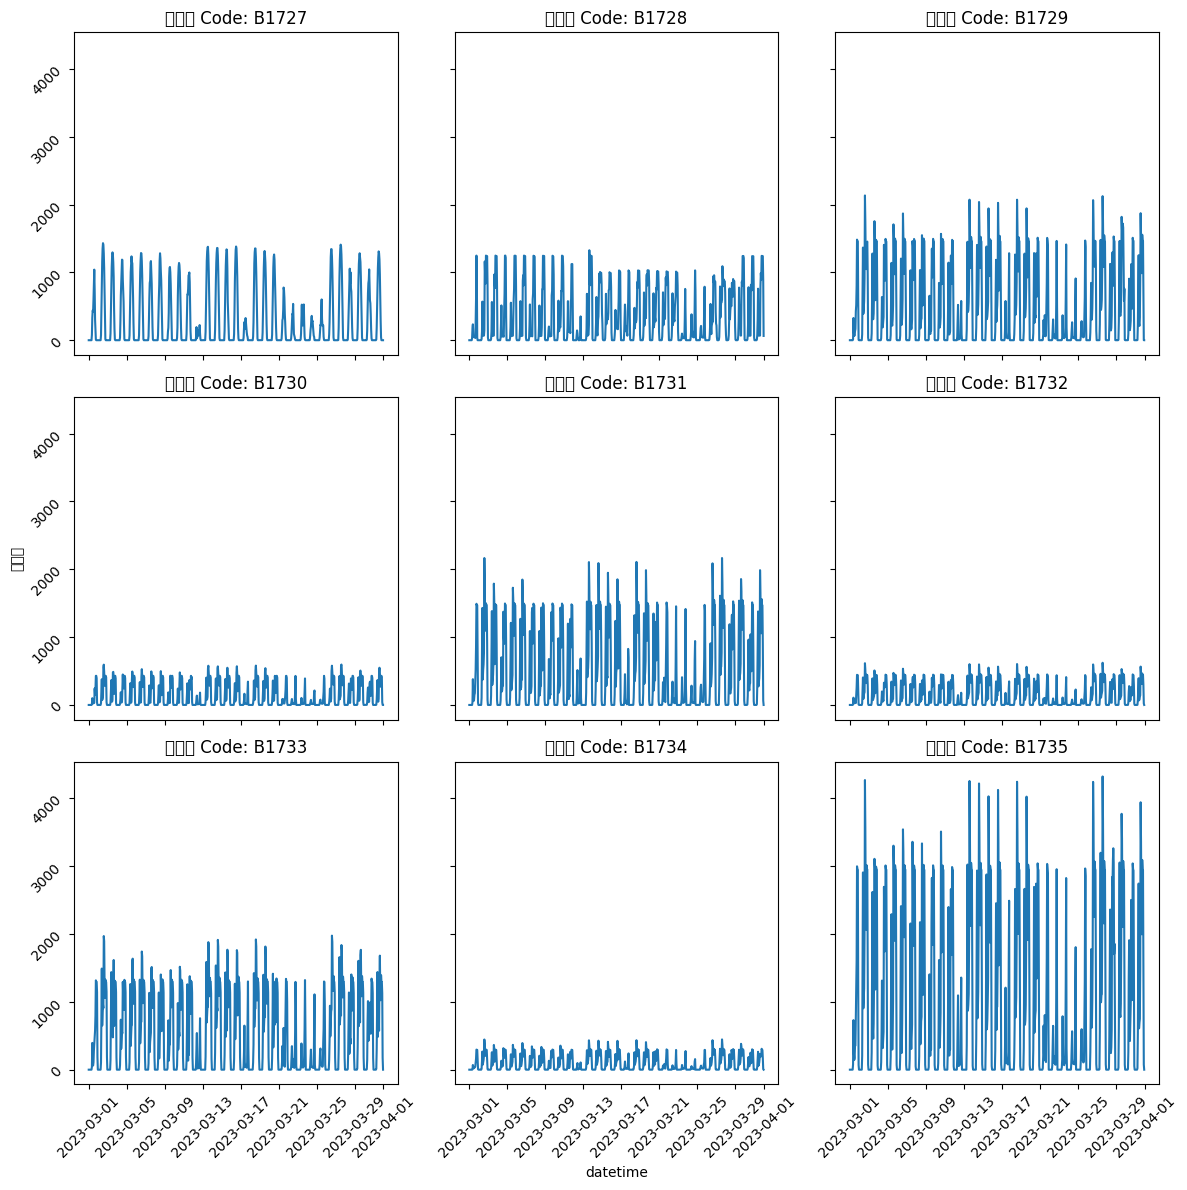

In [ ]:
unique_codes = df_combined['발전소코드'].unique()
num_plots = 9
num_rows = 3
num_cols = 3

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12), sharex=True, sharey=True)

for i, code in enumerate(unique_codes[:num_plots]):
    row = i // num_cols
    col = i % num_cols
    df_subset = df_combined[df_combined['발전소코드'] == code]
    axs[row, col].plot(df_subset['datetime'], df_subset['실측'])
    axs[row, col].set_title(f'발전소 Code: {code}')
    axs[row, col].tick_params(labelrotation=45)



axs[2][1].set_xlabel('datetime')
axs[1][0].set_ylabel('발전량')
plt.tight_layout()
plt.show()

# V. 모델링

우리는 모델링을 2 Depth로 나누어 진행하기로 했습니다.
- 먼저 Tensorflow를 활용하여 여러 column값을 통해 월 말일의 GRID ID별 '유동인구수'를 예측할 것입니다.
- 그리고 이를 바탕으로 최종데이터셋을 도출한 후에 Time Series Clustering 모델을 사용하여 '최적 예측형 집합자원'를 예측할 것입니다.

># i. 기본 데이터 수정본 전처리  

In [ ]:
df_combined["hour"] = df_combined['datetime'].dt.hour

In [ ]:
df_combined['hour']

0          0
1          0
2          0
3          0
4          0
          ..
125731    23
125732    23
125733    23
125734    23
125735    23
Name: hour, Length: 125736, dtype: int64

In [ ]:
df_pivot = df_combined.pivot(index='datetime', columns='발전소코드', values='gap')
df_pivot = df_pivot.reset_index()
df_pivot["hour"] = df_pivot['datetime'].astype("datetime64").dt.hour
df_pivot

발전소코드,datetime,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,...,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027,hour
0,2023-03-01 00:00:00,0.000000,0.136882,0.119883,0.188380,0.302346,0.182176,0.103572,0.234221,0.123131,...,0.0,0.133881,0.0,0.0,0.0,0.510204,0.426233,0.428359,0.0,0
1,2023-03-01 01:00:00,0.000000,0.147929,0.118855,0.185670,0.127838,0.159823,0.102515,0.241319,0.123847,...,0.0,0.136737,0.0,0.0,0.0,0.441114,0.419855,0.406037,0.0,1
2,2023-03-01 02:00:00,0.000000,0.148890,0.119197,0.185670,0.125808,0.153117,0.104981,0.246642,0.124383,...,0.0,0.134595,0.0,0.0,0.0,0.437925,0.423044,0.412415,0.0,2
3,2023-03-01 03:00:00,0.000000,0.154173,0.120910,0.184314,0.124794,0.148647,0.105686,0.230672,0.122057,...,0.0,0.136023,0.0,0.0,0.0,0.443240,0.418793,0.418793,0.0,3
4,2023-03-01 04:00:00,0.000000,0.151291,0.121938,0.184314,0.122427,0.150882,0.102868,0.230672,0.118835,...,0.0,0.127811,0.0,0.0,0.0,0.436862,0.427296,0.424107,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2023-03-31 19:00:00,0.001218,2.122877,6.215395,5.720520,5.811879,5.180276,3.309730,4.302926,3.422424,...,0.0,2.674045,0.0,0.0,0.0,2.544643,2.076956,0.184949,0.0,19
740,2023-03-31 20:00:00,0.000000,2.849554,4.468878,6.226029,5.594420,3.469164,2.196858,3.004063,2.428609,...,0.0,1.631560,0.0,0.0,0.0,1.434949,1.020408,0.573980,0.0,20
741,2023-03-31 21:00:00,0.000000,3.573830,31.812024,13.964519,24.742676,19.191050,7.569577,24.238338,25.408049,...,0.0,31.866833,0.0,0.0,0.0,1.277636,0.913053,0.730230,0.0,21
742,2023-03-31 22:00:00,0.000000,24.586952,10.653103,1.345766,2.961234,6.766211,19.543085,0.019518,0.369929,...,0.0,27.069618,0.0,0.0,0.0,1.036352,0.698342,0.899235,0.0,22


In [ ]:
df_pivot = df_pivot.drop(columns=['datetime']).groupby('hour').mean()
df_pivot

발전소코드,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,B1736,...,V9018,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027
hour,,,,,,,,,,,,,,,,,,,,,
0,0.000000,1.056791,0.175879,0.261607,0.231729,0.223997,0.116561,0.251107,0.174177,0.000000,...,0.000000,0.000000,0.169145,0.000000,0.000000,0.000000,0.449412,0.437479,0.445228,0.000000
1,0.000000,0.321608,0.157737,0.215747,0.141005,0.182356,0.116357,0.252309,0.149560,0.000000,...,0.000000,0.000000,0.163179,0.000000,0.000000,0.000000,0.422976,0.437377,0.436211,0.000000
2,0.000000,0.250184,0.149461,0.214742,0.134263,0.177345,0.116073,0.256258,0.145346,0.000000,...,0.000000,0.000000,0.160565,0.000000,0.000000,0.000000,0.421536,0.437239,0.451880,0.000000
3,0.000000,0.245598,0.151085,0.213430,0.131012,0.170495,0.115584,0.261352,0.139752,0.000000,...,0.000000,0.000000,0.162189,0.000000,0.000000,0.000000,0.417935,0.438234,0.454795,0.000000
4,0.000000,0.246512,0.147063,0.212119,0.129714,0.167971,0.114698,0.265187,0.130757,0.000000,...,0.000000,0.000000,0.154231,0.000000,0.000000,0.000000,0.412586,0.433296,0.442005,0.000000
5,0.000000,0.266467,0.144290,0.215179,0.129823,0.166961,0.111107,0.269080,0.128113,0.000000,...,0.000000,0.000000,0.153701,0.000000,0.000099,0.000000,0.408746,0.428496,0.457504,0.000000
6,0.069681,0.280551,0.176067,0.241847,0.173439,0.222087,0.167154,0.289686,0.181827,0.035627,...,0.077770,0.064135,0.207276,0.047514,0.207114,0.091748,0.473379,0.489288,0.472282,0.054152
7,1.666559,0.733696,1.678731,1.531216,1.638685,1.757115,1.592175,1.208139,1.674353,1.097444,...,0.739538,0.752753,1.639115,2.303281,2.880297,2.476558,0.920665,1.165755,0.973125,1.359849
8,5.453037,1.913177,6.179938,5.744040,6.173780,6.474939,6.302153,4.910974,5.991963,1.974643,...,2.908331,2.700385,6.395009,5.292191,7.627886,7.321178,2.106683,3.062939,3.225258,4.906589


In [ ]:
df_pivot_actual = df_combined.pivot(index='datetime', columns='발전소코드', values='actual_average')
df_pivot_actual

발전소코드,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,B1736,...,V9018,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027
datetime,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0
2023-03-01 01:00:00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0
2023-03-01 02:00:00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0
2023-03-01 03:00:00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0
2023-03-01 04:00:00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 19:00:00,0.0,1242.0,1464.00,428.62,1468.32,437.83,1293.36,290.06,2952.96,0.0,...,0.0,0.0,1458.72,0.0,0.0,0.0,429.56,459.21,437.51,0.0
2023-03-31 20:00:00,0.0,1238.4,1463.76,412.13,1468.80,437.83,1293.60,290.35,2940.48,0.0,...,0.0,0.0,1458.48,0.0,0.0,0.0,461.38,490.30,457.76,0.0
2023-03-31 21:00:00,0.0,1240.2,651.12,41.33,896.40,293.11,1126.08,166.90,1460.64,0.0,...,0.0,0.0,594.72,0.0,0.0,0.0,459.93,488.86,456.31,0.0


In [ ]:
df_pivot_predict = df_combined.pivot(index='datetime', columns='발전소코드', values='predict_average')
df_pivot_predict

발전소코드,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,B1736,...,V9018,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027
datetime,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,0.00,2.85,3.50,1.39,8.94,1.63,2.94,1.32,6.88,0.0,...,0.0,0.0,3.75,0.0,0.0,0.0,4.80,4.01,4.03,0.0
2023-03-01 01:00:00,0.00,3.08,3.47,1.37,3.78,1.43,2.91,1.36,6.92,0.0,...,0.0,0.0,3.83,0.0,0.0,0.0,4.15,3.95,3.82,0.0
2023-03-01 02:00:00,0.00,3.10,3.48,1.37,3.72,1.37,2.98,1.39,6.95,0.0,...,0.0,0.0,3.77,0.0,0.0,0.0,4.12,3.98,3.88,0.0
2023-03-01 03:00:00,0.00,3.21,3.53,1.36,3.69,1.33,3.00,1.30,6.82,0.0,...,0.0,0.0,3.81,0.0,0.0,0.0,4.17,3.94,3.94,0.0
2023-03-01 04:00:00,0.00,3.15,3.56,1.36,3.62,1.35,2.92,1.30,6.64,0.0,...,0.0,0.0,3.58,0.0,0.0,0.0,4.11,4.02,3.99,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 19:00:00,0.02,1197.80,1645.46,470.83,1640.17,484.18,1387.31,314.31,3144.19,0.0,...,0.0,0.0,1533.62,0.0,0.0,0.0,453.50,478.75,439.25,0.0
2023-03-31 20:00:00,0.00,1179.07,1594.23,458.07,1634.22,468.87,1355.96,307.28,3076.18,0.0,...,0.0,0.0,1504.18,0.0,0.0,0.0,474.88,499.90,463.16,0.0
2023-03-31 21:00:00,0.00,1165.79,1579.88,144.37,1628.01,464.82,1340.95,303.50,2880.33,0.0,...,0.0,0.0,1487.31,0.0,0.0,0.0,471.95,497.45,463.18,0.0


In [ ]:
# 발전소 코드 리스트
plant_list = df_error['발전소코드'].tolist()
print(plant_list)

['B1727', 'B1728', 'B1729', 'B1730', 'B1731', 'B1732', 'B1733', 'B1734', 'B1735', 'B1736', 'B1737', 'B1738', 'B1739', 'B1740', 'B1741', 'B1742', 'B1743', 'B1776', 'B1777', 'B1778', 'B1779', 'B1780', 'B1781', 'B1782', 'B1783', 'B1784', 'B1785', 'B1786', 'B1787', 'B1788', 'B1789', 'B1790', 'B1791', 'B1792', 'B1793', 'B1794', 'B1795', 'G1017', 'G1018', 'G1019', 'G1020', 'G1021', 'G1022', 'G1023', 'G1024', 'G1025', 'G1026', 'G1027', 'G1028', 'G1029', 'G1030', 'G1031', 'G1032', 'G1033', 'G1034', 'G1039', 'G1050', 'G1051', 'G1052', 'G1053', 'G1054', 'G1055', 'G1056', 'G1057', 'G1058', 'G1059', 'G1060', 'G1061', 'G1062', 'G1063', 'G1064', 'G1065', 'G1066', 'G1067', 'G1068', 'M1201', 'M1202', 'M1203', 'M1204', 'M1205', 'M1206', 'M1207', 'M1208', 'N6001', 'N6002', 'N6003', 'N6004', 'N6005', 'N6006', 'N6007', 'N6008', 'N6009', 'S5001', 'S5002', 'S5003', 'S5004', 'S5005', 'S5006', 'S5007', 'S5008', 'S5009', 'S5010', 'S5011', 'S5012', 'S5013', 'S5014', 'S5015', 'S5016', 'S5017', 'S5018', 'S5019', 

In [ ]:
df_pivot

발전소코드,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,B1736,...,V9018,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027
hour,,,,,,,,,,,,,,,,,,,,,
0,0.000000,1.056791,0.175879,0.261607,0.231729,0.223997,0.116561,0.251107,0.174177,0.000000,...,0.000000,0.000000,0.169145,0.000000,0.000000,0.000000,0.449412,0.437479,0.445228,0.000000
1,0.000000,0.321608,0.157737,0.215747,0.141005,0.182356,0.116357,0.252309,0.149560,0.000000,...,0.000000,0.000000,0.163179,0.000000,0.000000,0.000000,0.422976,0.437377,0.436211,0.000000
2,0.000000,0.250184,0.149461,0.214742,0.134263,0.177345,0.116073,0.256258,0.145346,0.000000,...,0.000000,0.000000,0.160565,0.000000,0.000000,0.000000,0.421536,0.437239,0.451880,0.000000
3,0.000000,0.245598,0.151085,0.213430,0.131012,0.170495,0.115584,0.261352,0.139752,0.000000,...,0.000000,0.000000,0.162189,0.000000,0.000000,0.000000,0.417935,0.438234,0.454795,0.000000
4,0.000000,0.246512,0.147063,0.212119,0.129714,0.167971,0.114698,0.265187,0.130757,0.000000,...,0.000000,0.000000,0.154231,0.000000,0.000000,0.000000,0.412586,0.433296,0.442005,0.000000
5,0.000000,0.266467,0.144290,0.215179,0.129823,0.166961,0.111107,0.269080,0.128113,0.000000,...,0.000000,0.000000,0.153701,0.000000,0.000099,0.000000,0.408746,0.428496,0.457504,0.000000
6,0.069681,0.280551,0.176067,0.241847,0.173439,0.222087,0.167154,0.289686,0.181827,0.035627,...,0.077770,0.064135,0.207276,0.047514,0.207114,0.091748,0.473379,0.489288,0.472282,0.054152
7,1.666559,0.733696,1.678731,1.531216,1.638685,1.757115,1.592175,1.208139,1.674353,1.097444,...,0.739538,0.752753,1.639115,2.303281,2.880297,2.476558,0.920665,1.165755,0.973125,1.359849
8,5.453037,1.913177,6.179938,5.744040,6.173780,6.474939,6.302153,4.910974,5.991963,1.974643,...,2.908331,2.700385,6.395009,5.292191,7.627886,7.321178,2.106683,3.062939,3.225258,4.906589


In [ ]:
# 특성 스케일링
hours = df_pivot.index
scaler = StandardScaler()

scaled_error_data = scaler.fit_transform(df_pivot)


df_scaled = pd.DataFrame(scaled_error_data, columns=df_pivot.columns)
df_scaled.set_index(hours, inplace=True)
df_T_scaled = df_scaled.T

># ii. 최적의 클러스터 개수 찾기

>>## 1. KMeans
1. Elbow
2. Silhouette

Elbow 메서드 그래프 출력
올라가는 부분이 있을때, 최적점

Silhouette 계수

Silhouette 계수는 (b(i) - a(i)) / max(a(i), b(i))로 계산됩니다.

In [ ]:
max_clusters = 20

In [ ]:
df_scaled

발전소코드,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,B1736,...,V9018,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027
hour,,,,,,,,,,,,,,,,,,,,,
0,-0.809595,-0.779465,-0.952293,-1.019498,-0.852236,-0.949074,-1.058141,-0.900284,-0.885432,-0.771808,...,-0.784967,-0.793990,-0.894803,-0.817479,-0.771701,-0.790458,-0.862426,-0.969692,-0.911508,-0.826868
1,-0.809595,-0.894769,-0.955589,-1.028251,-0.865276,-0.957896,-1.058184,-0.900074,-0.890037,-0.771808,...,-0.784967,-0.793990,-0.895571,-0.817479,-0.771701,-0.790458,-0.869983,-0.969722,-0.914106,-0.826868
2,-0.809595,-0.905971,-0.957092,-1.028443,-0.866245,-0.958958,-1.058244,-0.899382,-0.890825,-0.771808,...,-0.784967,-0.793990,-0.895907,-0.817479,-0.771701,-0.790458,-0.870395,-0.969762,-0.909592,-0.826868
3,-0.809595,-0.906690,-0.956797,-1.028693,-0.866713,-0.960409,-1.058347,-0.898490,-0.891871,-0.771808,...,-0.784967,-0.793990,-0.895698,-0.817479,-0.771701,-0.790458,-0.871424,-0.969472,-0.908752,-0.826868
4,-0.809595,-0.906547,-0.957528,-1.028943,-0.866899,-0.960944,-1.058535,-0.897819,-0.893554,-0.771808,...,-0.784967,-0.793990,-0.896723,-0.817479,-0.771701,-0.790458,-0.872953,-0.970910,-0.912436,-0.826868
5,-0.809595,-0.903417,-0.958031,-1.028359,-0.866884,-0.961158,-1.059293,-0.897137,-0.894048,-0.771808,...,-0.784967,-0.793990,-0.896791,-0.817479,-0.771671,-0.790458,-0.874051,-0.972307,-0.907972,-0.826868
6,-0.793189,-0.901208,-0.952259,-1.023270,-0.860614,-0.949479,-1.047451,-0.893529,-0.884001,-0.762138,...,-0.762985,-0.775573,-0.889894,-0.805421,-0.709264,-0.768516,-0.855575,-0.954609,-0.903714,-0.811523
7,-0.417226,-0.830138,-0.679310,-0.777193,-0.649999,-0.624255,-0.746354,-0.732706,-0.604837,-0.473953,...,-0.575932,-0.577824,-0.705562,-0.232935,0.096597,-0.198187,-0.727710,-0.757680,-0.759425,-0.441547
8,0.474248,-0.645153,0.138305,0.026827,0.001878,0.375300,0.248829,-0.084332,0.202736,-0.235875,...,0.037091,-0.018525,-0.093298,0.525613,1.527811,0.960408,-0.388664,-0.205382,-0.110604,0.563441


In [ ]:
inertia = []
silhouette_scores = []
for k in range(2, max_clusters+1):
    e_kmeans = KMeans(n_clusters=k)
    e_kmeans.fit(df_T_scaled)
    inertia.append(e_kmeans.inertia_) # ELBOW

    # Silhouette 계수 계산
    s_labels = e_kmeans.labels_
    silhouette_avg = silhouette_score(df_T_scaled, s_labels)
    silhouette_scores.append(silhouette_avg)

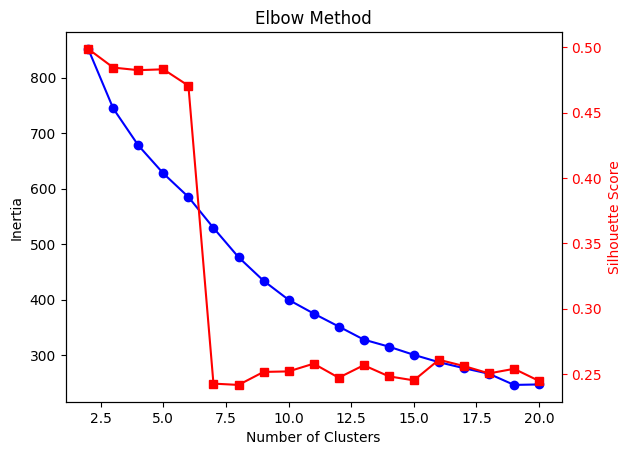

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(range(2, max_clusters+1), inertia, 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')

# Silhouette 그래프 출력
ax2 = ax1.twinx()
ax2.plot(range(2, max_clusters+1), silhouette_scores, 'rs-')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params('y', colors='r')

plt.show()

>>## 2. Gaussian Mixture
 1. Elbow
 2. Silhouette

In [ ]:
max_clusters = 20
n_components = range(2, max_clusters+1)
bic_scores = []
silhouette_scores = []

for k in n_components:
    gmm = GaussianMixture(n_components=k)
    gmm.fit(df_T_scaled)

    # BIC 계산
    bic_scores.append(gmm.bic(df_T_scaled))

    # Silhouette 계수 계산
    s_labels = gmm.predict(df_T_scaled)
    silhouette_avg = silhouette_score(df_T_scaled, s_labels)
    silhouette_scores.append(silhouette_avg)

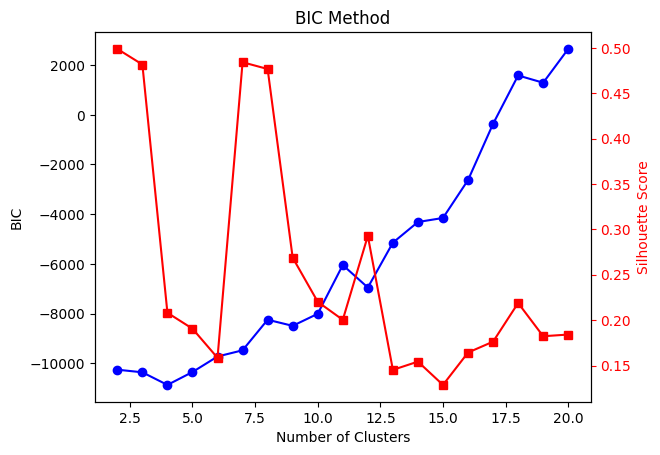

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(n_components, bic_scores, 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('BIC')
ax1.set_title('BIC Method')

# Silhouette 그래프 출력
ax2 = ax1.twinx()
ax2.plot(n_components, silhouette_scores, 'rs-')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params('y', colors='r')

plt.show()

>>## 3. Hierarchy Clustering
1. 덴드로그램(Dendrogram)

 (1) Single linkage

 (2) complete linkage

 (3) average linkage  

덴드로그램은 클러스터의 병합 단계를 시각화

singe: 두 클러스터 내의 가장 가까운 점 사이의 거리

complete: 가장 먼 점 사이의 거리

average: 모든 점 사이의 평균 거리

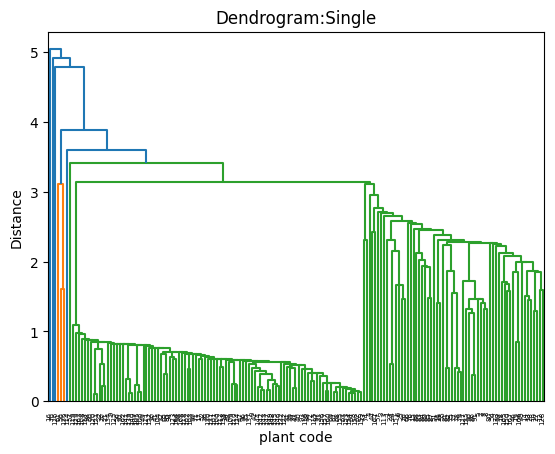

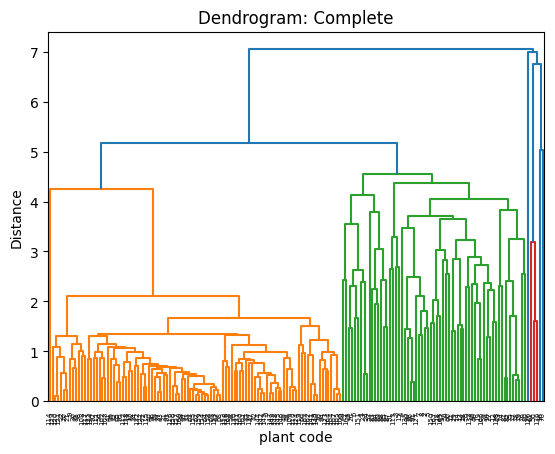

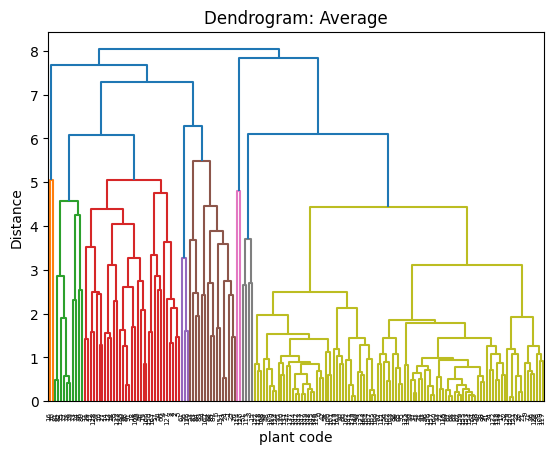

In [ ]:
hc = AgglomerativeClustering(n_clusters=max_clusters)
hc.fit(df_T_scaled)

hc_single = linkage(df_T_scaled, method='single')
hc_avg = linkage(df_T_scaled, method='average')
hc_complete = linkage(df_T_scaled, method='complete')

plt.xlabel('plant code')
plt.ylabel('Distance')
plt.title('Dendrogram:Single')
dendrogram(hc_single)
plt.show()

plt.xlabel('plant code')
plt.ylabel('Distance')
plt.title('Dendrogram: Complete')
dendrogram(hc_avg)
plt.show()

plt.xlabel('plant code')
plt.ylabel('Distance')
plt.title('Dendrogram: Average')
dendrogram(hc_complete)
plt.show()

>> ## 4. DBSCAN

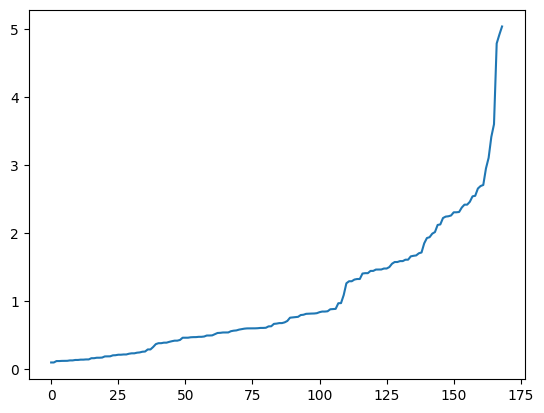

In [ ]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(df_T_scaled)
distances, indices = neighbors_fit.kneighbors(df_T_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

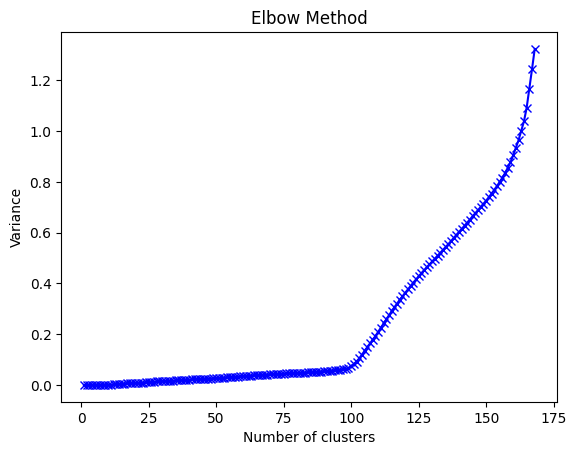

In [ ]:
# NearestNeighbors 라이브러리
from sklearn.neighbors import NearestNeighbors

# 5-NN 거리 계산합니다.
n_neighbors = 5
neighbors = NearestNeighbors(n_neighbors=n_neighbors)
distances, _ = neighbors.fit(df_T_scaled).kneighbors(df_T_scaled)

# 거리 기준으로 샘플 정렬합니다.
sorted_distances = np.sort(distances[:, -1])
# 엘보우 메소드를 통한 최적의 클러스터 개수 추정합니다.
variances = []
for i in range(1, len(sorted_distances)):
    variances.append(np.var(sorted_distances[:i]))
# 엘보우 메소드 계산합니다.
diff = np.diff(variances)
knee = np.argmax(diff) + 1
# 시각화
plt.plot(range(1, len(sorted_distances)), variances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Variance')
plt.title('Elbow Method')
# plt.axhline(knee, color='r', linestyle='--')
plt.show()

In [ ]:
# nn = NearestNeighbors(n_neighbors=20).fit(df_T_scaled)
# distances, indices = nn.kneighbors(df_T_scaled)

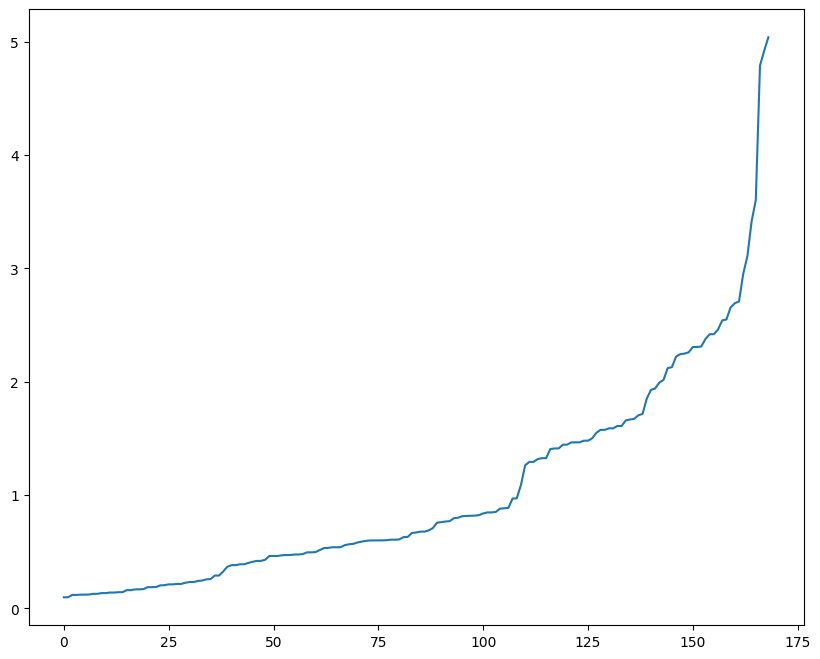

In [ ]:
# distances = np.sort(distances, axis=0)
# distances = distances[:,1]
# plt.figure(figsize=(10,8))
# plt.plot(distances)

In [ ]:
min_samples = range(10,21)
eps = np.arange(1,1.5, 0.1)

In [ ]:
output = []

for ms in min_samples:
    for ep in eps:
        labels = DBSCAN(min_samples=ms, eps = ep).fit_predict(df_T_scaled)
        score = silhouette_score(df_T_scaled, labels)
        output.append((ms, ep, score))

In [ ]:
min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")

Best silhouette_score: 0.4959411192521596
min_samples: 20
eps: 1.4000000000000004


># iii. 클러스터링 알고리즘 적용
1. K-MEANS
2. Gaussian Mixture
3. Hierarchy Clustering
4. DBSCAN

>>## 1. K-MEANS

In [ ]:
# K-means 알고리즘을 사용하여 클러스터링 모델 학습
kmeans = KMeans(n_clusters=10, init='k-means++')  # 클러스터 개수는 상황에 맞게 설정합니다
kmeans.fit(df_T_scaled)

KMeans(n_clusters=10)

In [ ]:
km = TimeSeriesKMeans(n_clusters=7, metric="euclidean")

labels = km.fit_predict(df_T_scaled)
# 학습된 클러스터링 모델로 데이터를 예측 (각 데이터 포인트가 속한 클러스터를 예측)

cluster_count = math.ceil(math.sqrt(len(set(labels))))
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN



In [ ]:
labels
score = silhouette_score(df_T_scaled, labels)
print(score)

0.4959411192521596


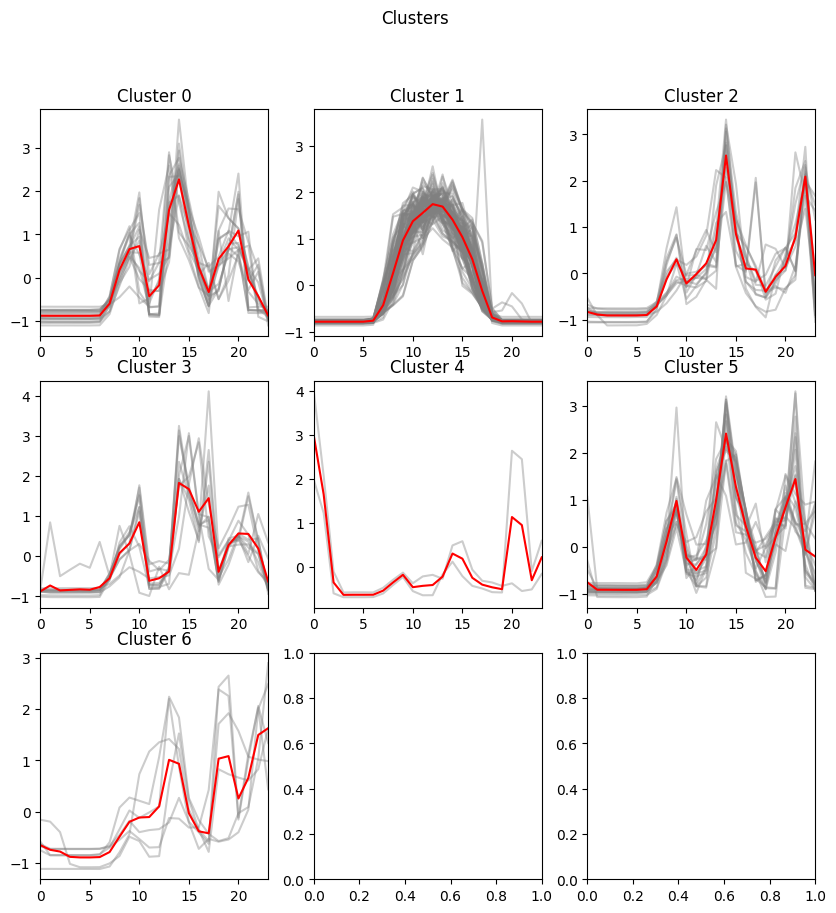

In [ ]:
plot_count = math.ceil(math.sqrt(len(set(labels))))


fig, axs = plt.subplots(plot_count,plot_count,figsize=(10,10))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], df_scaled[plant_list[i]].values ,c="gray",alpha=0.4)
                cluster.append(df_scaled[plant_list[i]].values)
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*plot_count+column_j))
    axs[row_i, column_j].set_xlim(0, 23)
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0


plt.show()

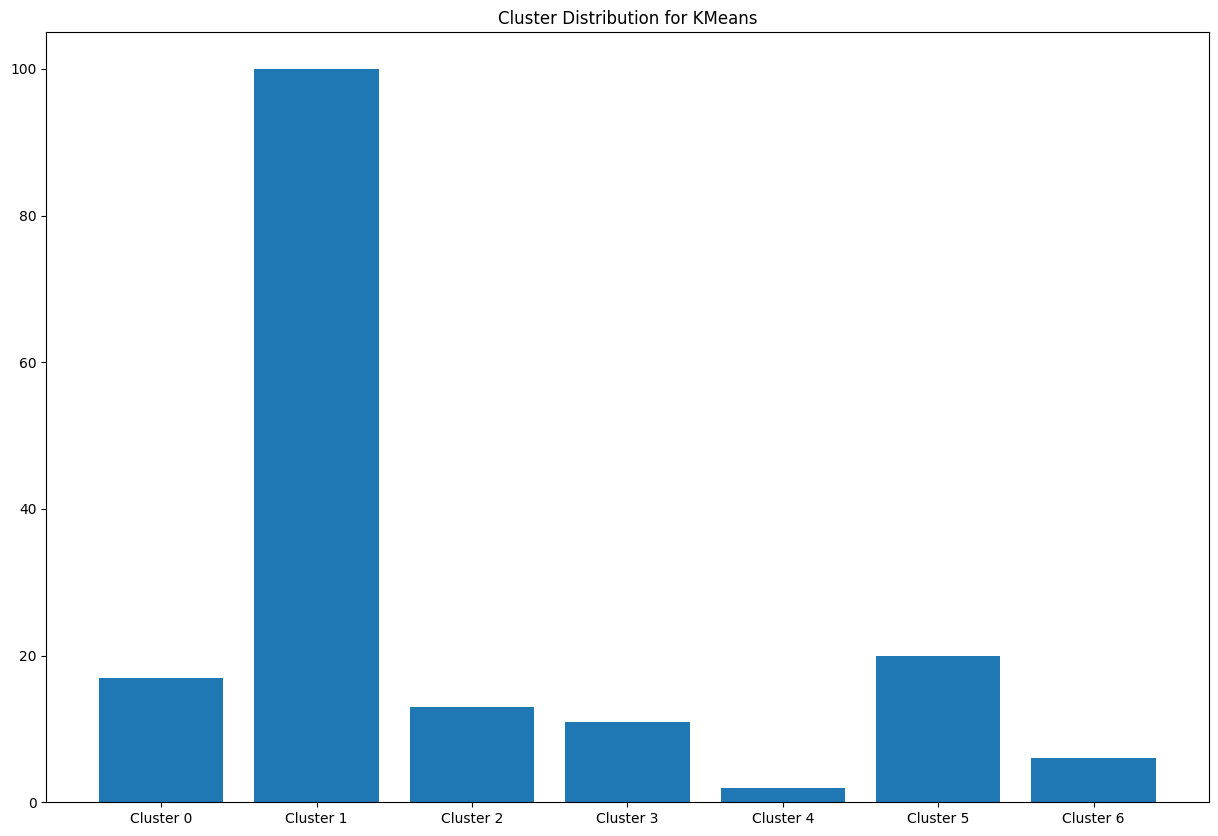

In [ ]:
cluster_c = [len(labels[labels==i]) for i in range(len(set(labels)))]
cluster_n = ["Cluster "+str(i) for i in range(len(set(labels)))]
plt.figure(figsize=(15,10))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [ ]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
p = pd.DataFrame(zip(plant_list,fancy_names_for_labels),columns=["plant code","Cluster"]).sort_values(by="Cluster").set_index("plant code")
p = p.sort_index()

In [ ]:
p

,Cluster
plant code,
B1727,Cluster 1
B1728,Cluster 2
B1729,Cluster 5
B1730,Cluster 0
B1731,Cluster 5
...,...
V9023,Cluster 1
V9024,Cluster 5
V9025,Cluster 5


>>## 2. Gaussian Mixture

In [ ]:
gmm = GaussianMixture(n_components = 8)
gmm.fit(df_T_scaled)
labels = gmm.fit_predict(df_T_scaled)
labels

array([0, 3, 2, 2, 2, 2, 3, 2, 2, 4, 2, 2, 2, 2, 2, 2, 5, 0, 2, 2, 4, 4,
       4, 3, 3, 3, 3, 2, 2, 2, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0,
       3, 2, 2, 0, 0, 0, 7, 2, 0, 3, 2, 2, 0, 3, 0, 2, 0, 7, 0, 0, 0, 0,
       2, 0, 0, 0, 6, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 3,
       3, 3, 2, 2, 4, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 0, 2, 4, 0, 0, 4, 0, 0, 4, 4, 0, 0, 0, 4, 1, 1, 2, 4, 0, 0,
       0, 2, 4, 2, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 2, 3, 0])

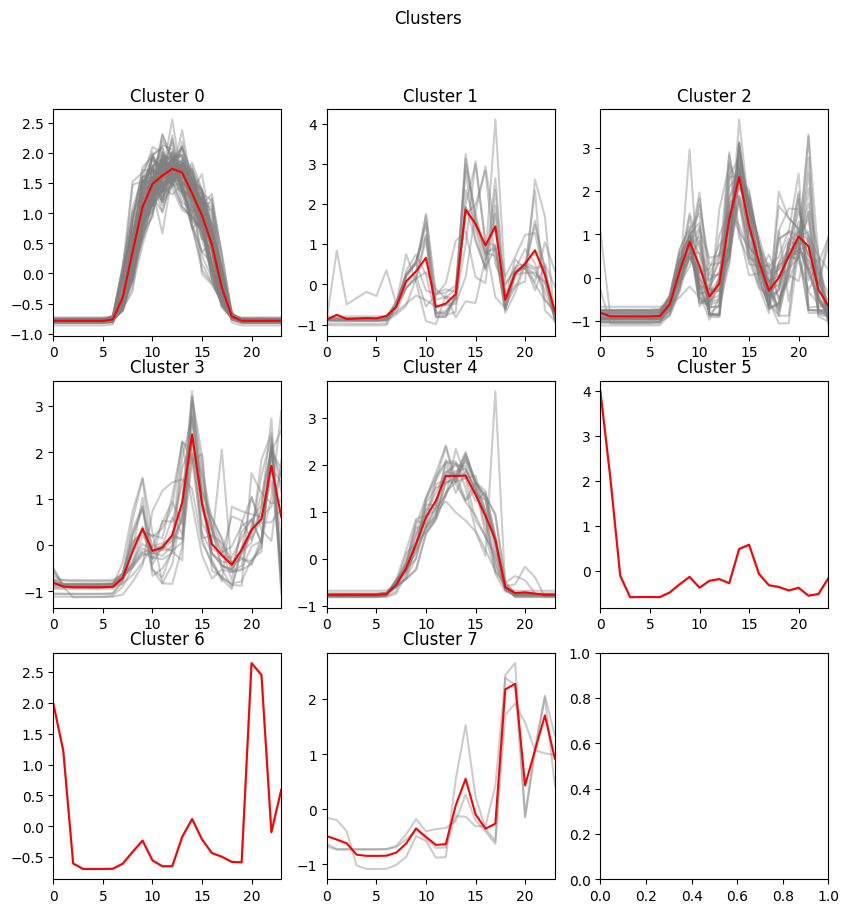

In [ ]:
plot_count = math.ceil(math.sqrt(len(set(labels))))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(10,10))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], df_scaled[plant_list[i]].values ,c="gray",alpha=0.4)
                cluster.append(df_scaled[plant_list[i]].values)
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*plot_count+column_j))
    axs[row_i, column_j].set_xlim(0, 23)
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0


plt.show()

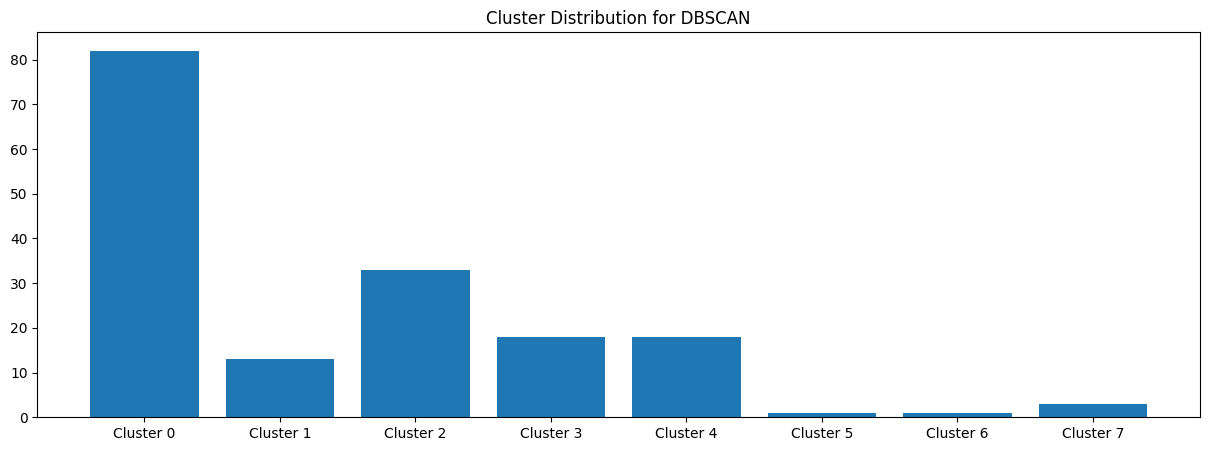

In [ ]:
cluster_c = [len(labels[labels==i]) for i in range(len(set(labels)))]
cluster_n = ["Cluster "+str(i) for i in range(len(set(labels)))]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for DBSCAN")
plt.bar(cluster_n,cluster_c)
plt.show()

In [ ]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
p = pd.DataFrame(zip(plant_list,fancy_names_for_labels),columns=["plant code","Cluster"]).sort_values(by="Cluster").set_index("plant code")
p = p.sort_index()

In [ ]:
p

,Cluster
plant code,
B1727,Cluster 0
B1728,Cluster 3
B1729,Cluster 2
B1730,Cluster 2
B1731,Cluster 2
...,...
V9023,Cluster 0
V9024,Cluster 3
V9025,Cluster 2


>>## 3. Hierarchy Clustering

In [ ]:
hcluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='average')
labels = hcluster.fit_predict(df_T_scaled)
labels

0.4436924981108787


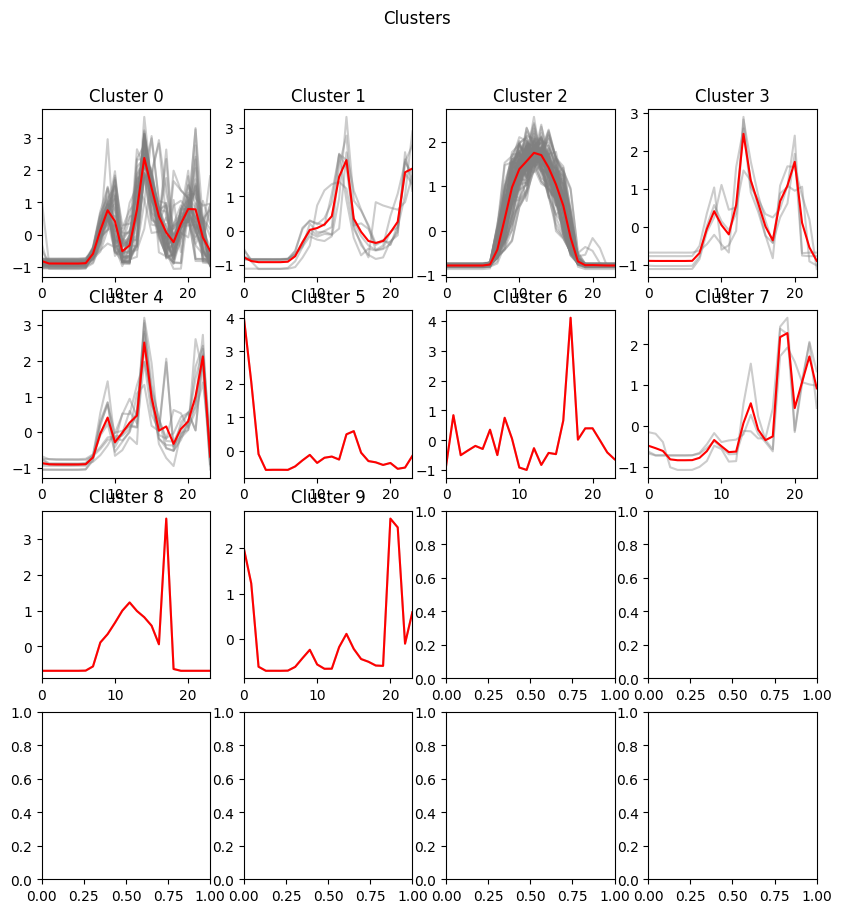

In [ ]:
plot_count = math.ceil(math.sqrt(len(set(labels))))


fig, axs = plt.subplots(plot_count,plot_count,figsize=(10,10))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], df_scaled[plant_list[i]].values ,c="gray",alpha=0.4)
                cluster.append(df_scaled[plant_list[i]].values)
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*plot_count+column_j))
    axs[row_i, column_j].set_xlim(0, 23)
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.show()

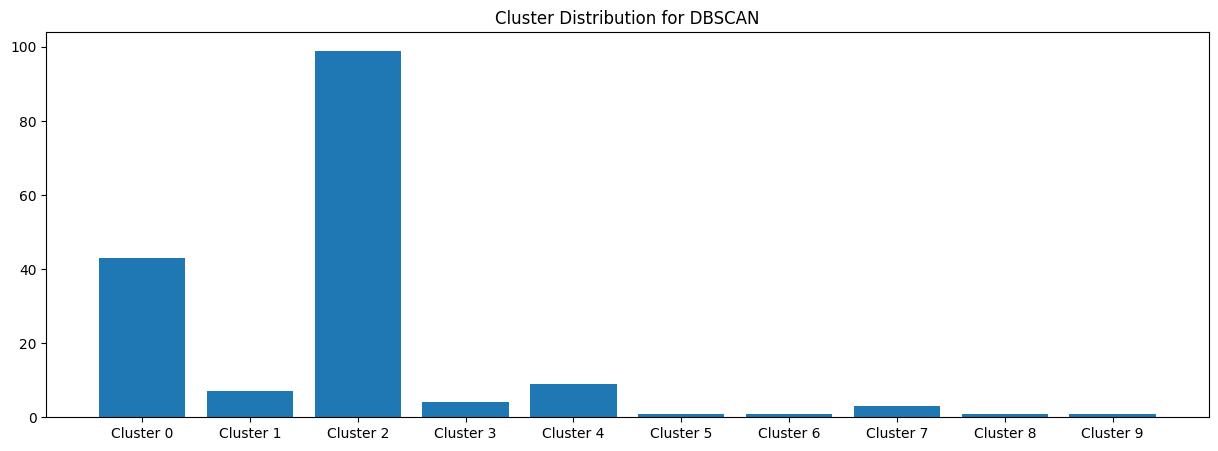

In [ ]:
cluster_c = [len(labels[labels==i]) for i in range(len(set(labels)))]
cluster_n = ["Cluster "+str(i) for i in range(len(set(labels)))]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for DBSCAN")
plt.bar(cluster_n,cluster_c)
plt.show()

In [ ]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
p = pd.DataFrame(zip(plant_list,fancy_names_for_labels),columns=["plant code","Cluster"]).sort_values(by="Cluster").set_index("plant code")
p = p.sort_index()

In [ ]:
p

,Cluster
plant code,
B1727,Cluster 4
B1728,Cluster 1
B1729,Cluster 0
B1730,Cluster 6
B1731,Cluster 0
...,...
V9023,Cluster 4
V9024,Cluster 0
V9025,Cluster 0


>>## 4. DBSCAN

In [ ]:
# labels = dbscan_dtw(df_T_scaled, eps=0.5, min_samples=3)

In [ ]:
dbscan = DBSCAN(eps=1.4, min_samples=20, metric='euclidean')
labels = dbscan.fit_predict(df_T_scaled)
print(labels)

[ 0 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  0  0  0 -1
 -1 -1 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  0
  0  0 -1 -1  0 -1 -1 -1  0 -1  0 -1  0 -1  0  0  0  0 -1  0  0  0 -1  0
  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0
  0  0  0  0  0  0 -1 -1 -1  0  0  0  0 -1  0 -1 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1 -1 -1
  0]


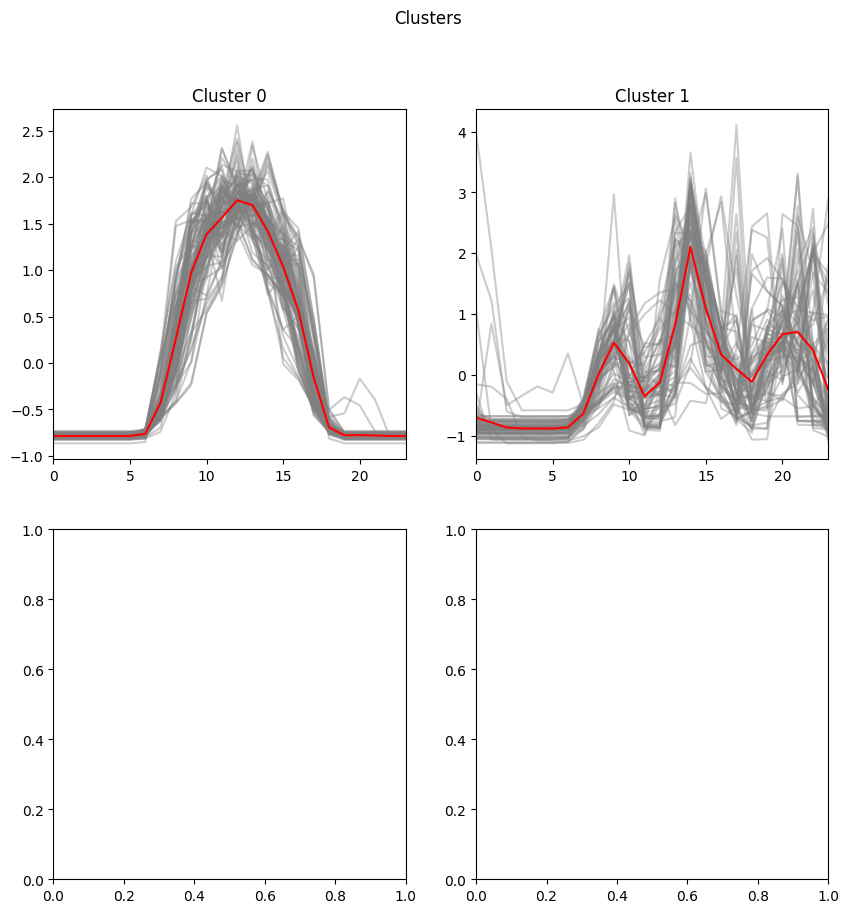

In [ ]:
plot_count = math.ceil(math.sqrt(len(set(labels))))


fig, axs = plt.subplots(plot_count,plot_count,figsize=(10,10))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], df_scaled[plant_list[i]].values ,c="gray",alpha=0.4)
                cluster.append(df_scaled[plant_list[i]].values)
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*plot_count+column_j))
    axs[row_i, column_j].set_xlim(0, 23)
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.show()

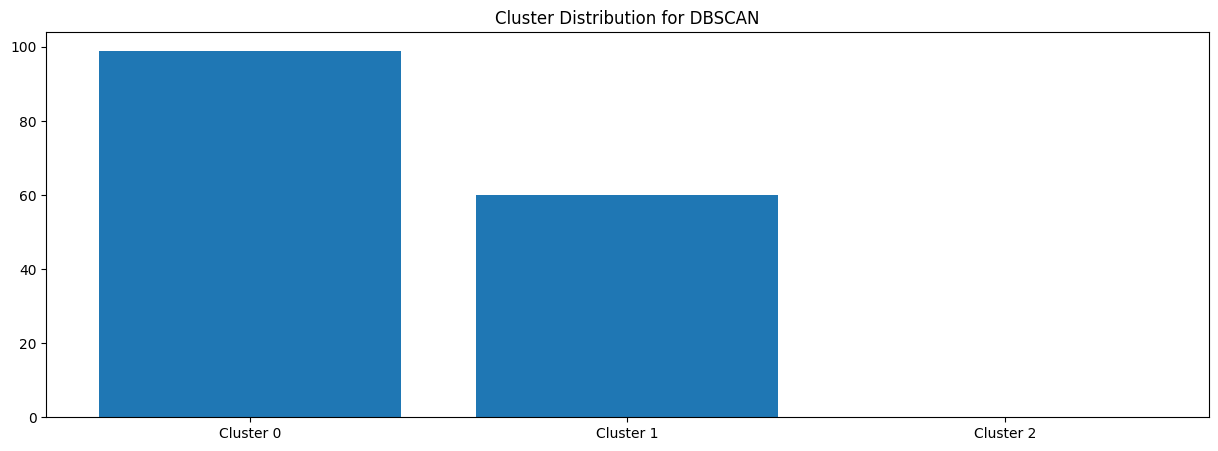

In [ ]:
cluster_c = [len(labels[labels==i]) for i in range(len(set(labels)))]
cluster_n = ["Cluster "+str(i) for i in range(len(set(labels)))]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for DBSCAN")
plt.bar(cluster_n,cluster_c)
plt.show()

In [ ]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
p = pd.DataFrame(zip(plant_list,fancy_names_for_labels),columns=["plant code","Cluster"]).sort_values(by="Cluster").set_index("plant code")
p = p.sort_index()

In [ ]:
p

,Cluster
plant code,
B1727,Cluster 1
B1728,Cluster -1
B1729,Cluster -1
B1730,Cluster -1
B1731,Cluster -1
...,...
V9023,Cluster -1
V9024,Cluster -1
V9025,Cluster -1


># iv. Silhouette 계수를 이용하여 적합성을 확인

In [ ]:
def get_silhouette_results(X, labels):
    def get_sum_distance(target_x, target_cluster):
        res = np.sum([np.linalg.norm(target_x-x) for x in target_cluster])
        return res

    '''
    각 데이터 포인트를 돌면서 a(i), b(i)를 계산
    그리고 s(i)를 계산한다.

    마지막으로 Silhouette(실루엣) Coefficient를 계산한다.
    '''
    uniq_labels = np.unique(labels)
    silhouette_val_list = []
    for i in range(len(labels)):
        target_data = X[i]

        ## calculate a(i)
        target_label = labels[i]
        target_cluster_data_idx = np.where(labels==target_label)[0]
        if len(target_cluster_data_idx) == 1:
            silhouette_val_list.append(0)
            continue
        else:
            target_cluster_data = X[target_cluster_data_idx]
            temp1 = get_sum_distance(target_data, target_cluster_data)
            a_i = temp1/(target_cluster_data.shape[0]-1)

        ## calculate b(i)
        b_i_list = []
        label_list = uniq_labels[np.unique(labels) != target_label]
        for ll in label_list:
            other_cluster_data_idx = np.where(labels==ll)[0]
            other_cluster_data = X[other_cluster_data_idx]
            temp2 = get_sum_distance(target_data, other_cluster_data)
            temp_b_i = temp2/other_cluster_data.shape[0]
            b_i_list.append(temp_b_i)

        b_i = min(b_i_list)
        s_i = (b_i-a_i)/max(a_i, b_i)
        silhouette_val_list.append(s_i)

    silhouette_coef_list = []
    for ul in uniq_labels:
        temp3 = np.mean([s for s, l in zip(silhouette_val_list, labels) if l == ul])
        silhouette_coef_list.append(temp3)

    silhouette_coef = max(silhouette_coef_list)
    return (silhouette_coef, np.array(silhouette_val_list))

In [ ]:
silhouette_coef, silhouette_list = get_silhouette_results(df_T_scaled, labels)
print(silhouette_coef)

KeyError: ignored

# 시각화


## DBSCAN 클러스터링별 발전소코드 출력

In [ ]:
for cluster_id in range(0,7):
  cluster = df_error[df_error['클러스터'] == cluster_id]
  print(cluster)

In [ ]:
mean = 4.72
std = 3.69

cluster_3_normalized = df_error[df_error['클러스터'] == 0]['오차율'].values
cluster_3_original = (cluster_3_normalized * std) + mean

print('정규화 이후 평균 오차율: ', df_error[df_error['클러스터'] == 0]['오차율'].mean())

cluster_3_original_list = cluster_3_original.tolist()
print(cluster_3_original_list)

sum = 0
for i in range(len(cluster_3_original_list)):
  sum += cluster_3_original_list[i]

print('정규화 이전 평균 오차율: ',sum / 9)

In [ ]:
mean = 4.72
std = 3.69

cluster_3_normalized = df_error[df_error['클러스터'] == 1]['오차율'].values
cluster_3_original = (cluster_3_normalized * std) + mean

print('정규화 이후 평균 오차율: ', df_error[df_error['클러스터'] == 1]['오차율'].mean())

cluster_3_original_list = cluster_3_original.tolist()
print(cluster_3_original_list)

sum = 0
for i in range(len(cluster_3_original_list)):
  sum += cluster_3_original_list[i]

print('정규화 이전 평균 오차율: ',sum / 9)

In [ ]:
mean = 4.72
std = 3.69

cluster_3_normalized = df_error[df_error['클러스터'] == 5]['오차율'].values
cluster_3_original = (cluster_3_normalized * std) + mean

print('정규화 이후 평균 오차율: ', df_error[df_error['클러스터'] == 5]['오차율'].mean())

cluster_3_original_list = cluster_3_original.tolist()
print(cluster_3_original_list)

sum = 0
for i in range(len(cluster_3_original_list)):
  sum += cluster_3_original_list[i]

print('정규화 이전 평균 오차율: ',sum / 9)


In [ ]:
mean = 4.72
std = 3.69

cluster_4_normalized = df_error[df_error['클러스터'] == 6]['오차율'].values
cluster_4_original = (cluster_4_normalized * std) + mean

print('정규화 이후 평균 오차율: ', df_error[df_error['클러스터'] == 5]['오차율'].mean())

cluster_4_original_list = cluster_4_original.tolist()
print(cluster_4_original_list)

sum = 0
for i in range(len(cluster_4_original_list)):
  sum += cluster_4_original_list[i]

print('정규화 이후 평균 오차율: ', sum / len(cluster_4_original_list))

## 발전량 평균 그래프

실측, 예측 데이터 추출하여 확인

In [ ]:
print(df)

In [ ]:
actual_data = df[df['구분1'] == '실측']
predict_data = df[df['구분1'] == '예측']

In [ ]:
# 발전량 데이터가 있는 시간대 열만 추출
a_time_columns = actual_data.columns[4:-1]
p_time_columns = predict_data.columns[4:-1]

In [ ]:
# 실측 발전량 데이터프레임을 actual_mySeries에 추가
for a_time_column in a_time_columns:
    a_series_df = pd.DataFrame({
        "구분1": actual_data["구분1"],
        "발전소코드": actual_data["발전소코드"],
        "발전소용량(KW)": actual_data["발전소용량(KW)"],
        "시간대": a_time_column,
        "발전량": actual_data[a_time_column],
        "합계": actual_data["합계"]
    })

    actual_mySeries.append(a_series_df)
print(a_series_df)

In [ ]:
# 예측 발전량 데이터프레임을 predict_mySeries에 추가
for p_time_column in p_time_columns:
    p_series_df = pd.DataFrame({
        "구분1": predict_data["구분1"],
        "발전소코드": predict_data["발전소코드"],
        "발전소용량(KW)": predict_data["발전소용량(KW)"],
        "시간대" : p_time_column,
        "발전량" : predict_data[p_time_column],
        "합계": predict_data["합계"]
    })
    predict_mySeries.append(p_series_df)



In [ ]:
total_sum = 0

for p_series_df in predict_mySeries:
    sum_values = p_series_df["합계"]
    total_sum += sum_values
for p_time_column in p_time_columns:
  total_sum["발전소코드"] = predict_data["발전소코드"]

print("전체 합계값:", total_sum)

In [ ]:
a_mean = []

for i in range(len(actual_mySeries)-1):
  a_mean.append(actual_mySeries[i]["발전량"].mean())

#막대 그래프
x = [i for i in range(24)]
y = [a_mean[i] for i in range(0, 24)]
plt.bar(x, y, width=0.7, color="dodgerblue")

#선 그래프
cv_list = {
            'actual':a_mean,
          }
df = pd.DataFrame.from_dict(cv_list)

plt.plot(x, y, color = 'black')
plt.show()


## 예측 발전량 평균
p_mean = []

for i in range(len(predict_mySeries)-1):
  p_mean.append(predict_mySeries[i]["발전량"].mean())

#막대 그래프
x = [i for i in range(24)]
y = [p_mean[i] for i in range(0, 24)]
plt.bar(x, y, width=0.7, color="orange")

#선 그래프
cv_list = {
            'predict':p_mean,
          }
df = pd.DataFrame.from_dict(cv_list)

plt.plot(x, y, color = 'black')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math


# 예측값과 실제값
a1 = 4354523.11 ; b1 = 3511887.23; c1 = 3166034.76; d1 = 4960745.24; e1 = 2475917.15;
f1 = 3308213.12; g1 = 3169832.59

a2 = 4225454.84 ; b2 = 3422719.00; c2 = 3117116.40; d2 = 4789083.64; e2 = 2418353.16;
f2 = 3218884.96; g2 = 3013800.80


# predicted = [ b1,a1,f1,g1,c1,e1,d1]
# predicted = [4354523.11, 3511887.23, 3166034.76, 4960745.24, 2475917.15, 3308213.12, 3169832.59]
# actual = [4225454.84, 3422719.00, 3117116.40, 4789083.64, 2418353.16,3218884.96, 3013800.80]
# actual = [ b2,a2,f2,g2,c2,e2,d2]

predicted = [1088630.7799999998,877971.8099999997, 791508.69, 1240186.31, 618979.2899999996, 827053.2800000014, 792458.1499999997]
actual = [1056363.71, 855679.7500000001, 779279.1000000001, 1205811.8199999998, 604588.2900000003,804721.2400000001, 753450.2000000002]

# 정상금 오차율 계산
error_rates = [(a - p) / p * 100 for p, a in zip(predicted, actual)]

# 데이터 포인트 인덱스
indices = np.arange(len(predicted))

# 도표 생성
plt.figure(figsize=(8, 6))
plt.bar(indices, error_rates, color='blue')

# 레이블 및 제목 설정
plt.xlabel('Clustering Numbers')
plt.ylabel('Normalcy Return Error Rate (%)')
plt.title('Normalcy Return Error Rate')

# X축 레이블 위치 및 값 설정
plt.xticks(indices)
plt.gca().set_xticklabels(indices)

# Y축 범위 설정
plt.ylim(min(error_rates) - 1, max(error_rates) + 1)

# 오차율 값 표시
for i, rate in enumerate(error_rates):
    plt.text(i, rate + 0.5, f'{rate:.2f}%', ha='center', va='bottom')

# 도표 출력
plt.show()

># VI. 결론

>>## i. Summary


In [ ]:
result = pd.read_csv('/content/최적_조합_Data_File(win).csv', encoding = 'CP949')
result.head()

In [ ]:
result.describe()

>>## ii. 향후 모델 활용 방안